In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time
import os
from tqdm import tqdm

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터셋이 위치한 경로
# 여러분들이 다운로드 받은 데이터셋의 경로를 찍어주시면 됩니다.
data_dir = '/content/drive/MyDrive/Parrot DL Project'

In [4]:
# 이미지 변환
# 이리저리 바꿔보면서 좋은 성능이 나오도록 하시면 됩니다.
# 다만 validation은 건들지 말아주세요
data_transforms = {
    'train': transforms.Compose([ # 원본 이미지 그대로
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# 여기는 건들지 말아주세요!

# 이미지 데이터셋 불러오기
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

# 클래스명
class_names = full_dataset.classes

In [6]:
type(full_dataset), len(full_dataset)

(torchvision.datasets.folder.ImageFolder, 15874)

In [7]:
len(class_names), class_names[:10]

(200,
 ['001.Black_footed_Albatross',
  '002.Laysan_Albatross',
  '003.Sooty_Albatross',
  '004.Groove_billed_Ani',
  '005.Crested_Auklet',
  '006.Least_Auklet',
  '007.Parakeet_Auklet',
  '008.Rhinoceros_Auklet',
  '009.Brewer_Blackbird',
  '010.Red_winged_Blackbird'])

In [8]:
full_dataset[0]

(tensor([[[-1.3644, -1.2959, -1.2274,  ...,  0.2111,  0.2796,  0.3309],
          [-1.3302, -1.3130, -1.2617,  ...,  0.2111,  0.2453,  0.2796],
          [-1.2617, -1.2788, -1.2617,  ...,  0.3309,  0.3138,  0.3481],
          ...,
          [-0.9192, -0.8507, -0.7308,  ..., -0.4054, -0.3712, -0.2684],
          [-0.7650, -1.0048, -0.9877,  ..., -0.4911, -0.4739, -0.4054],
          [-0.9534, -1.0048, -1.0219,  ..., -0.5767, -0.6452, -0.6623]],
 
         [[-0.4426, -0.4601, -0.4776,  ...,  0.8704,  0.9055,  0.9055],
          [-0.4076, -0.4601, -0.4776,  ...,  0.8354,  0.8704,  0.8880],
          [-0.4426, -0.4251, -0.4426,  ...,  0.9055,  0.8880,  0.9755],
          ...,
          [-0.9153, -0.7402, -0.5826,  ...,  0.3277,  0.4153,  0.4328],
          [-0.7227, -0.8277, -0.7227,  ...,  0.1352,  0.1527,  0.1877],
          [-0.8277, -0.8627, -0.8452,  ..., -0.0049, -0.0224,  0.0126]],
 
         [[ 0.1302,  0.2348,  0.2173,  ...,  1.6291,  1.6465,  1.6640],
          [ 0.1476,  0.1825,

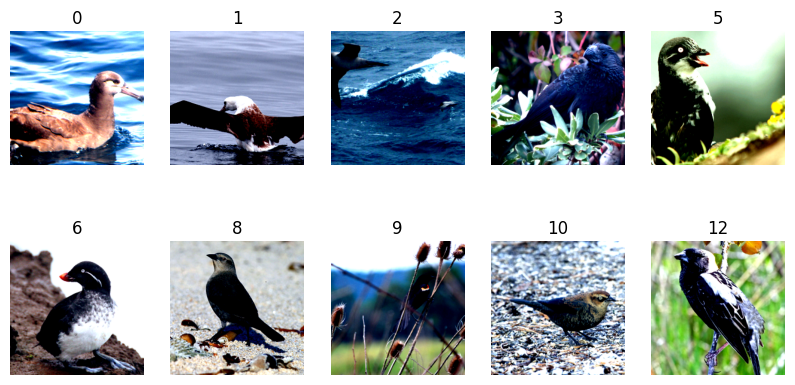

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10,5))

cnt = 1
for i in range(0, 1000, 100):
  image, label = full_dataset[i]
  image = np.transpose(image, (1, 2, 0)) # (3, 224, 224) --> (224, 224, 3)
  image = image / 2 + 0.5  # [0, 1] 범위로 정규화

  plt.subplot(2, 5, cnt)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  cnt += 1

plt.show()

In [10]:
# 데이터셋을 train과 valid로 나누기
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(train_size, valid_size)
print(train_dataset[0][0].shape)

12699 3175
torch.Size([3, 224, 224])


In [11]:
# GPU 사용 가능 확인
# device(type='cuda', index=0) 가 뜬다면 GPU에서 훈련이 가능해지고 더 빨라집니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=46fb04ae629d02114b1d4e9e6cedc903daa658745da1a5bf319994dc0c702500
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [13]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

class EfficientNetCustom(nn.Module):
    def __init__(self, freeze=False):
        super(EfficientNetCustom, self).__init__()
        self.pretrained_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        if freeze:
            for param in self.pretrained_efficientnet.parameters():
                param.requires_grad = False

        # 예측에 사용되는 EfficientNet의 마지막 계층들을 새로이 정의
        self.pretrained_efficientnet._fc = nn.Sequential(
            nn.Linear(1280, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 200)
        )

    def forward(self, input):
        return self.pretrained_efficientnet(input)

# 모델 생성 및 장치로 이동
model = EfficientNetCustom(freeze=False).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 307MB/s]


Loaded pretrained weights for efficientnet-b0


In [14]:
print(model)

EfficientNetCustom(
  (pretrained_efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): 

In [15]:
# 손실함수 설정
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Scheduler 설정
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

num_epochs=30

In [16]:
# 모델 학습과 평가
# 이 부분은 건드셔도 되고 안건드셔도 됩니다.
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for phase in ['train', 'valid']:
        if phase == 'train':
            dataloader = train_loader
            model.train()
        else:
            dataloader = valid_loader
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            step_lr_scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        if phase == 'train':
          train_loss_list.append(epoch_loss)
          train_acc_list.append(epoch_acc.cpu().numpy())
        else:
          valid_loss_list.append(epoch_loss)
          valid_acc_list.append(epoch_acc.cpu().numpy())


        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

print('Training complete')

Epoch 1/30
----------


100%|██████████| 397/397 [1:36:20<00:00, 14.56s/it]


train Loss: 5.0566 Acc: 0.0606


100%|██████████| 100/100 [24:04<00:00, 14.45s/it]


valid Loss: 4.0799 Acc: 0.1805
Epoch 2/30
----------


100%|██████████| 397/397 [02:17<00:00,  2.89it/s]


train Loss: 3.4002 Acc: 0.2569


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


valid Loss: 2.2801 Acc: 0.5178
Epoch 3/30
----------


100%|██████████| 397/397 [02:16<00:00,  2.92it/s]


train Loss: 2.1426 Acc: 0.4627


100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


valid Loss: 1.4693 Acc: 0.6652
Epoch 4/30
----------


100%|██████████| 397/397 [02:17<00:00,  2.89it/s]


train Loss: 1.5446 Acc: 0.5924


100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


valid Loss: 1.0798 Acc: 0.7420
Epoch 5/30
----------


100%|██████████| 397/397 [02:16<00:00,  2.91it/s]


train Loss: 1.1728 Acc: 0.6878


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


valid Loss: 0.8648 Acc: 0.7764
Epoch 6/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.93it/s]


train Loss: 0.9394 Acc: 0.7418


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


valid Loss: 0.7517 Acc: 0.8057
Epoch 7/30
----------


100%|██████████| 397/397 [02:14<00:00,  2.94it/s]


train Loss: 0.7887 Acc: 0.7828


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


valid Loss: 0.6674 Acc: 0.8170
Epoch 8/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.94it/s]


train Loss: 0.6749 Acc: 0.8108


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


valid Loss: 0.6134 Acc: 0.8208
Epoch 9/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.93it/s]


train Loss: 0.5787 Acc: 0.8396


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


valid Loss: 0.5647 Acc: 0.8381
Epoch 10/30
----------


100%|██████████| 397/397 [02:17<00:00,  2.90it/s]


train Loss: 0.5047 Acc: 0.8605


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


valid Loss: 0.5308 Acc: 0.8466
Epoch 11/30
----------


100%|██████████| 397/397 [02:16<00:00,  2.91it/s]


train Loss: 0.4303 Acc: 0.8829


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


valid Loss: 0.5062 Acc: 0.8554
Epoch 12/30
----------


100%|██████████| 397/397 [02:17<00:00,  2.90it/s]


train Loss: 0.3858 Acc: 0.8950


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


valid Loss: 0.4834 Acc: 0.8580
Epoch 13/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.93it/s]


train Loss: 0.3462 Acc: 0.9067


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


valid Loss: 0.4713 Acc: 0.8624
Epoch 14/30
----------


100%|██████████| 397/397 [02:13<00:00,  2.97it/s]


train Loss: 0.3212 Acc: 0.9125


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


valid Loss: 0.4556 Acc: 0.8661
Epoch 15/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.93it/s]


train Loss: 0.2809 Acc: 0.9278


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


valid Loss: 0.4451 Acc: 0.8724
Epoch 16/30
----------


100%|██████████| 397/397 [02:14<00:00,  2.95it/s]


train Loss: 0.2536 Acc: 0.9333


100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


valid Loss: 0.4346 Acc: 0.8740
Epoch 17/30
----------


100%|██████████| 397/397 [02:13<00:00,  2.98it/s]


train Loss: 0.2338 Acc: 0.9379


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


valid Loss: 0.4318 Acc: 0.8750
Epoch 18/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.94it/s]


train Loss: 0.2161 Acc: 0.9442


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


valid Loss: 0.4285 Acc: 0.8781
Epoch 19/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.93it/s]


train Loss: 0.2036 Acc: 0.9468


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


valid Loss: 0.4226 Acc: 0.8775
Epoch 20/30
----------


100%|██████████| 397/397 [02:12<00:00,  2.99it/s]


train Loss: 0.1871 Acc: 0.9523


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


valid Loss: 0.4200 Acc: 0.8794
Epoch 21/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.92it/s]


train Loss: 0.1749 Acc: 0.9544


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


valid Loss: 0.4149 Acc: 0.8844
Epoch 22/30
----------


100%|██████████| 397/397 [02:13<00:00,  2.96it/s]


train Loss: 0.1608 Acc: 0.9602


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


valid Loss: 0.4173 Acc: 0.8838
Epoch 23/30
----------


100%|██████████| 397/397 [02:14<00:00,  2.95it/s]


train Loss: 0.1513 Acc: 0.9633


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


valid Loss: 0.4136 Acc: 0.8809
Epoch 24/30
----------


100%|██████████| 397/397 [02:14<00:00,  2.95it/s]


train Loss: 0.1437 Acc: 0.9649


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


valid Loss: 0.4126 Acc: 0.8847
Epoch 25/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.92it/s]


train Loss: 0.1395 Acc: 0.9643


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


valid Loss: 0.4124 Acc: 0.8831
Epoch 26/30
----------


100%|██████████| 397/397 [02:14<00:00,  2.95it/s]


train Loss: 0.1273 Acc: 0.9687


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


valid Loss: 0.4089 Acc: 0.8831
Epoch 27/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.93it/s]


train Loss: 0.1215 Acc: 0.9709


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


valid Loss: 0.4120 Acc: 0.8863
Epoch 28/30
----------


100%|██████████| 397/397 [02:15<00:00,  2.92it/s]


train Loss: 0.1143 Acc: 0.9735


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


valid Loss: 0.4117 Acc: 0.8876
Epoch 29/30
----------


100%|██████████| 397/397 [02:14<00:00,  2.96it/s]


train Loss: 0.1079 Acc: 0.9755


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


valid Loss: 0.4110 Acc: 0.8860
Epoch 30/30
----------


100%|██████████| 397/397 [02:16<00:00,  2.91it/s]


train Loss: 0.1069 Acc: 0.9746


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]

valid Loss: 0.4095 Acc: 0.8860
Training complete


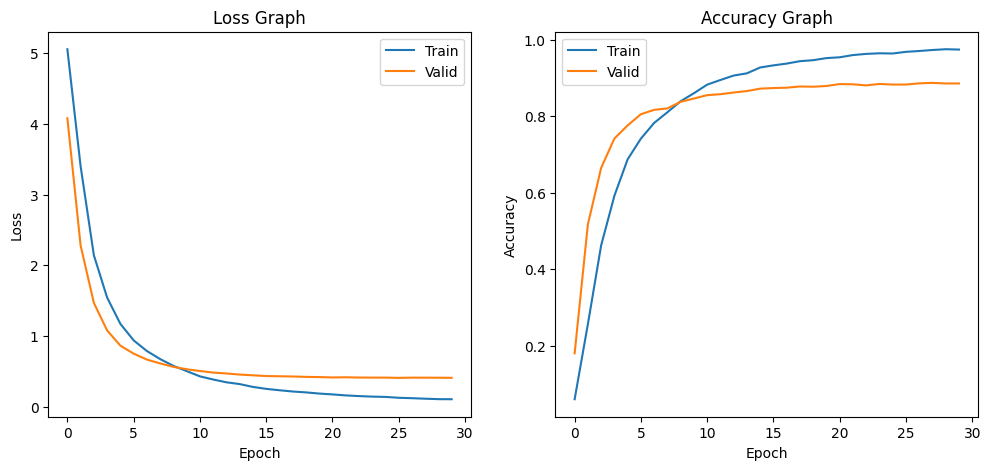

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(valid_loss_list, label='Valid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train')
plt.plot(valid_acc_list, label='Valid')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()

plt.show()

In [18]:
# 전체 모델 저장하는 부분입니다.
# PATH에는 저장할 경로를 지정해주세요
PATH = './'
torch.save(model, PATH + 'model.pt')